<a href="https://colab.research.google.com/github/Itziar23/prueba/blob/master/principal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import os
from google.colab import drive
drive.mount('/content/gdrive')
ruta='gdrive/My Drive/dataset/CAMUS/'

Mounted at /content/gdrive


In [3]:
pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os

%matplotlib inline

In [5]:
print(os.getcwd())

/content


In [6]:
#sys.path.append("gdrive/My Drive/dataset/Colab Notebooks/architectures")

import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/architectures')


from laddernet import LadderNet
from unet import UNet

In [7]:

import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/metrics')


from multiclass_dice import multiclass_dice

In [8]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 7
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [9]:
train_path = ruta + "training/patient0001/"

In [10]:
def mhd_to_array(path):
    """
    Read an *.mhd file stored in path and return it as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

In [11]:
image = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_2CH_ED.mhd", sitk.sitkFloat32))
mask = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_2CH_ED_gt.mhd", sitk.sitkFloat32))

In [12]:
np.shape(image)

(1, 778, 549)

In [13]:
np.shape(mask)

(1, 778, 549)

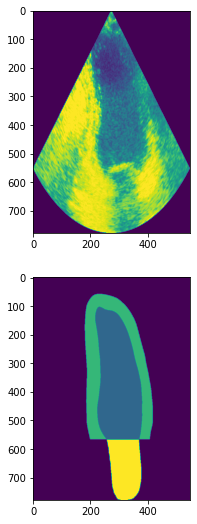

In [14]:
fig, ax = plt.subplots(2)
ax[0].imshow(image[0]) # End Diastolic frame
ax[1].imshow(mask[0]) # End Diastolic mask
plt.show()

In [15]:
image = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_4CH_ED.mhd", sitk.sitkFloat32))
mask = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_4CH_ED_gt.mhd", sitk.sitkFloat32))

In [16]:
np.shape(image)

(1, 778, 549)

In [17]:
np.shape(mask)

(1, 778, 549)

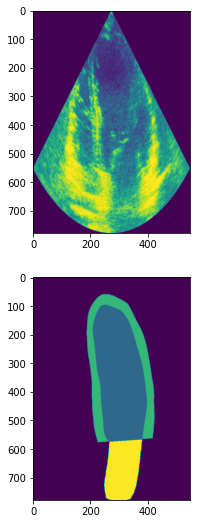

In [18]:
fig, ax = plt.subplots(2)
ax[0].imshow(image[0]) # End Diastolic frame
ax[1].imshow(mask[0]) # End Diastolic mask
plt.show()

In [19]:
# Standard
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Utils
import h5py

# Deep Learning
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model



In [20]:
model_laddernet = LadderNet(input_size=(384, 384, 1), num_classes=4, filters=20)
model_unet = UNet(input_size=(384, 384, 1), depth=5, num_classes=4, filters=10, batch_norm=True)

In [21]:
model_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 384, 384, 10  100         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_40 (BatchN  (None, 384, 384, 10  40         ['conv2d_30[0][0]']              
 ormalization)                  )                                                           

In [22]:
model_laddernet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 20  200         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 384, 384, 20  3620        ['conv2d[0][0]',                 
                                )                                 'dropout[0][0]']            

In [23]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

In [24]:
model_laddernet.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

In [25]:
f = h5py.File("gdrive/My Drive/dataset/image_dataset.hdf5", "r")

In [26]:
frames2ch = f["train 2ch frames"][:,:,:,:]
masks2ch = f["train 2ch masks"][:,:,:,:]

In [27]:
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ch, masks2ch)

In [28]:
model_laddernet.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=10,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/10
  1/135 [..............................] - ETA: 2:13:24 - loss: 1.3863 - multiclass_dice: 0.0000e+00 - accuracy: 1.0000

KeyboardInterrupt: ignored